## 빅데이터 실습

### 다나와 무선청소기 상품분석

#### 데이터 수집

##### 셀레니움 사용

In [4]:
## 필수 라이브러리 사용등록
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
from urllib import parse    # url encode
from tqdm import tqdm
import time

In [5]:
## 웹드라이버로 크롬 오픈
driver = webdriver.Chrome()
url = r'https://search.danawa.com/dsearch.php?k1=%EC%97%90%EC%96%B4%EB%A9%94%EC%9D%B4%EB%93%9C+%EC%8A%A4%EB%A7%88%ED%8A%B8%ED%83%80%EC%9B%8C&module=goods&act=dispMain'
driver.get(url)
time.sleep(0.5)

In [6]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [7]:
prodItems = soup.select('ul.product_list > li.prod_item')

In [8]:
len(prodItems)

3

In [9]:
prodItems[0].select('p.prod_name > a')[0].text.strip().replace('\t', '')

'에어메이드 스마트타워 AMC-3501A'

In [10]:
# 만약에 수가 아닌 문자열이 들어왔을 때에는 False
prodItems[0].select('input')[1].get('value').isdecimal()

True

##### 다나와 무선청소기 웹크롤링 다시
- 가격외에는 안들어오도록 변환

In [11]:
## 검색어, 페이지를 변경하면서 URL생성함수
def getSearchPageUrl(keyword, page):
    ecKeyword = parse.quote(keyword)
    url = f'https://search.danawa.com/dsearch.php?query={ecKeyword}&originalQuery={ecKeyword}&previousKeyword={ecKeyword}&checkedInfo=N&volumeType=allvs&' + \
          f'page={page}&limit=120&sort=saveDESC&list=list&boost=true&tab=goods&addDelivery=N&coupangMemberSort=N&mode=simple&isInitTireSmartFinder=N&' + \
            'recommendedSort=N&defaultUICategoryCode=10325109&defaultPhysicsCategoryCode=72%7C80%7C81%7C0&defaultVmTab=3138&defaultVaTab=1098867&isZeroPrice=Y&' + \
            'quickProductYN=N&priceUnitSort=N&priceUnitSortOrder=A'
    return url

In [12]:
## 상품정보 추출하는 함수
def getProdItems(prodItems):    
    prodData = []

    for prodItem in prodItems:
        try:
            prodName = prodItem.select('p.prod_name > a')[0].text.strip()   # 상품명 가져오기
            specList = prodItem.select('div.spec_list')[0].text.strip().replace('\t', '')   # 상품 스팩목록 가져오기

            if prodItem.select('input')[1].get('value').isdecimal() == True:
                price = prodItem.select('input')[1].get('value')
            else :
                price = 0   # 문자열이 들어오는 것을 막음
            prodData.append([prodName, specList, price])
        except:
            pass
    
    return prodData

In [13]:
## 여러페이지 검색 후 크롤링하는 작업
driver = webdriver.Chrome()
# 암묵적으로 웹 자원 로드를 위해 3초정도 대기
driver.implicitly_wait(3.0)

keyword = '무선청소기'
startPage = 1
total_page = 20
prodDataTotal = []  # 최종적으로 저장할 리스트

for page in tqdm(range(startPage, total_page+1)):
    # 검색 페이지 이동
    url = getSearchPageUrl(keyword, page)
    driver.get(url)
    # 페이지 로딩이 완료될때까지 5초간 대기
    time.sleep(5)
    
    # 현재 페이지 html 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # 상품정보 추출
    prodItems = soup.select('ul.product_list > li.prod_item')
    prodItemList = getProdItems(prodItems)  # 리스트로 추출하는 함수
    
    # 추출된 정보를 prodDataTotal 추가
    prodDataTotal += prodItemList

100%|██████████| 20/20 [03:59<00:00, 11.98s/it]


In [14]:
dfProdDataTotal = pd.DataFrame(prodDataTotal)

In [15]:
dfProdDataTotal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2120 non-null   object
 1   1       2120 non-null   object
 2   2       2120 non-null   object
dtypes: object(3)
memory usage: 49.8+ KB


In [16]:
dfProdDataTotal.columns = ['제품명', '제품스펙', '최저가']

In [17]:
dfProdDataTotal.to_excel('./data/다나와_무선청소기_결과.xlsx', index=False)

#### 크롤링 데이터 전처리

In [18]:
# 저장한 엑셀을 재로드
dfProdDanawa = pd.read_excel('./data/다나와_무선청소기_결과.xlsx')
dfProdDanawa.tail()

,제품명,제품스펙,최저가
2115,미니센 무선 소형 청소기 MNC-100 먼지통,차량용청소기 / 먼지통,7000
2116,프리라벨 2in1 무선 진공 청소기 LS-2000 헤파필터,차량용청소기 / 필터 / [필터] 헤파필터,3500
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2118,포쉬 워시젯 V2 WJ200,침구청소기 / 핸디형 / 무선 / 사용시간: 25분(최대) / [기능] 청소모드: ...,219000
2119,업킵 MJ-BC779,침구청소기 / 핸디형 / 무선 / [기능] 청소모드: UV살균 / 속도조절 / 헤파...,89900


In [19]:
dfProdDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2120 non-null   object
 1   제품스펙    2110 non-null   object
 2   최저가     2120 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 49.8+ KB


In [20]:
# 결측치 검색
condition = dfProdDanawa['제품스펙'].isnull() == True

In [21]:
dfProdDanawa[condition]

,제품명,제품스펙,최저가
1846,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1861,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1910,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1925,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1974,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1989,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2038,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2053,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2102,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0


In [22]:
#  결측치가 있는 행을 삭제
dfProdDanawa = dfProdDanawa.dropna(axis=0)

In [23]:
## 최저가가 0인 상품
condition = dfProdDanawa['최저가'] == 0

In [24]:
# 최저가가 0인 제품을 제외한 나머지
dfProdDanawa = dfProdDanawa[condition==False]

In [25]:
# 행들이 삭제되면서 인덱스가 꼬임. 인덱스 초기화
dfProdDanawa.reset_index(drop=True, inplace=True)

In [26]:
# 결측치, 이상치를 제거한 최종 DF
# 회사명, 모델명, 카테고리, 사용시간, 흡입력 추출한 결과도 2057개가 필수
dfProdDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2058 non-null   object
 1   제품스펙    2058 non-null   object
 2   최저가     2058 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 48.4+ KB


In [27]:
# 회사명, 제품명 분리 split(' ', n) n => 글자를 자를 공백의 번호
dfProdDanawa['제품명'][:5][0].split(' ', 1)

['LG전자', '오브제컬렉션 코드제로 A9S AX9884']

In [28]:
## 회사명, 모델명 분리 시작
compList = []
modelList = []

for temp in dfProdDanawa['제품명']:
    titles = temp.split(' ', 1) # 길이 2 배열 생성
    if (len(titles) > 1):
        compList.append(titles[0])  # 회사명
        modelList.append(titles[1]) # 모델명
    else:
        compList.append('')  # 회사명
        modelList.append(titles[0]) # 모델명
        

In [29]:
len(compList)

2058

In [30]:
len(modelList)

2058

In [31]:
# 스펙목록 데이터
specList = dfProdDanawa.loc[2000, '제품스펙'].split(' / ')

In [32]:
specList

['물걸레청소기',
 '회전식',
 '물걸레전용',
 '무선',
 '[배터리] 리튬이온',
 '2400mAh',
 '충전시간: 3시간',
 '사용시간: 1시간(최대)',
 '[기능] 물분사',
 'LED라이트',
 '각도조절',
 '셀프스탠딩',
 '[부가] 물통: 0.2L',
 '색상: 그레이',
 '패드: 극세사(벨크로형)',
 '크기(가로x세로x깊이): 330x1185x165mm']

In [33]:
useTime = ''
suctionPow = ''
for spec in specList:
    if '사용시간' in spec:
        useTime = spec
    elif '흡입력' in spec:
        suctionPow = spec

print(useTime.split(' ')[1].strip())
print(suctionPow.split(' ')[1].strip()) # 흡입력이 없어서 ''경우는 split(':')에서 예외발생

1시간(최대)


IndexError: list index out of range

In [34]:
dfProdDanawa.loc[1345]

제품명                            LG전자 오브제컬렉션 코드제로 A9S AX948
제품스펙    핸디스틱청소기 / 무선 / 흡입+물걸레(동시) / 흡입력: 320W / 소비전력: ...
최저가                                               1710000
Name: 1345, dtype: object

In [35]:
dfProdDanawa['제품스펙']

0       핸디스틱청소기 / 무선 / 흡입+물걸레(동시) / 흡입력: 250W / 소비전력: ...
1       핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 220W / 2022년형 / [구성]...
2       핸디스틱청소기 / 무선 / 흡입형 / 소비전력: 320W / 2023년형 / [구성...
3       핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 250W / 소비전력: 620W / ...
4       핸디스틱청소기 / 무선 / 흡입+물걸레(동시) / 흡입력: 280W / 소비전력: ...
                              ...                        
2053                                       차량용청소기 / 전용브러쉬
2054                                         차량용청소기 / 먼지통
2055                              차량용청소기 / 필터 / [필터] 헤파필터
2056    침구청소기 / 핸디형 / 무선 / 사용시간: 25분(최대) / [기능] 청소모드: ...
2057    침구청소기 / 핸디형 / 무선 / [기능] 청소모드: UV살균 / 속도조절 / 헤파...
Name: 제품스펙, Length: 2058, dtype: object

In [36]:
## 위의 테스트를 기반으로 카테고리, 사용시간, 흡입력 추출
categoryList = []
useTimeList = []
suctionPowList = []
count = 0

for spec in dfProdDanawa['제품스펙']:
    # ' / '로 문자열 분리
    specList = spec.split(' / ')
    # 카테고리 추출
    category = specList[0]
    categoryList.append(category)
    # 사용시간, 흡입력 추출
    useTimeVal = None
    suctionPowVal = None
    
    for temp in specList:
        if '사용시간' in temp:
            useTimeVal = temp.replace('[배터리] ', '')   # 1. [배터리]가 값 오류 발생시킴
        elif '흡입력' in temp:
            suctionPowVal = temp
            
    # 끝난 다음에도 사용시간, 흡입력이 None이면 스펙에 찾을 값이 없었음
    if useTimeVal != None:
        useTime = useTimeVal.split(' ')[1].strip().replace('(최대)', '')# 2. (최대) 삭제
    else:
        useTime = ''
    
    if suctionPowVal != None:
        suctionPow = suctionPowVal.split(' ')[1].strip()
    else:
        suctionPow = ''
        
    useTimeList.append(useTime)
    suctionPowList.append(suctionPow)
    count +=1

In [37]:
len(categoryList)

2058

In [38]:
useTimeList

['30분',
 '1시간',
 '',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '50분',
 '50분',
 '1시간30분',
 '1시간',
 '30분',
 '50분',
 '1시간',
 '12분',
 '30분',
 '1시간',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '43분',
 '43분',
 '1시간',
 '1시간',
 '40분',
 '53분',
 '40분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '50분',
 '20분',
 '10~15분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '45분',
 '',
 '18분',
 '1시간',
 '1시간',
 '30분',
 '40분',
 '42분',
 '1시간',
 '50분',
 '1시간',
 '50분',
 '30분',
 '60분',
 '30분',
 '32분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '1시간40분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '30분',
 '1시간',
 '40분',
 '30분',
 '40분',
 '30분',
 '30분',
 '30분',
 '30분',
 '1시간',
 '30분',
 '1시간',
 '',
 '57분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '35분',
 '20분',
 '50분',
 '40분',
 '45분',
 '45분',
 '30분',
 '40분',
 '1시간20분(대용량배터리기준)',
 '20분',
 '40분',
 '40분',
 '',
 '40분',
 '45분',
 '50분',
 '42분',
 '1시간',
 '1시간',
 '20분',
 '1시간',
 '28분',
 '20분',
 '50분',
 '1시간10분',
 '',
 '1시간',
 '1시간',


In [39]:
time = '1시간20분'
time.split('시간')[-1].split('분')[0]

'20'

In [40]:
## 사용시간 단위를 통일
# time = '1시간', '30분' , '1시간 20분' 등
def converHourToMin(time):
    try:
        if '시간' in time:
            hour = time.split('시간')[0]
            if '분' in time:
                minute = time.split('시간')[-1].split('분')[0]
            else:
                minute = 0
        else:
            hour = 0
            minute = time.split('분')[0]
        return int(hour)*60 + int(minute)
    except:
        return None

In [41]:
converHourToMin('1시간 30분')

90

In [42]:
newUseTimeList = []
for time in useTimeList:
    value = converHourToMin(time)
    newUseTimeList.append(value)

In [43]:
len(newUseTimeList)

2058

In [44]:
suctionPowList

['250W',
 '220W',
 '',
 '250W',
 '280W',
 '220W',
 '250W',
 '210W',
 '160W',
 '150W',
 '25000Pa',
 '250W',
 '9000Pa',
 '40000Pa',
 '220W',
 '',
 '280W',
 '151AW',
 '240AW',
 '280W',
 '220W',
 '220W',
 '',
 '115AW',
 '220W',
 '250W',
 '17000Pa',
 '17000Pa',
 '250W',
 '220W',
 '200W',
 '',
 '15000Pa',
 '130AW',
 '220W',
 '22000Pa',
 '',
 '35000Pa',
 '60W',
 '',
 '25000Pa',
 '220W',
 '',
 '250W',
 '',
 '',
 '22000Pa',
 '200W',
 '140AW',
 '250W',
 '12000Pa',
 '',
 '220W',
 '',
 '210W',
 '35000Pa',
 '250W',
 '',
 '280W',
 '23000Pa',
 '140AW',
 '27000Pa',
 '250W',
 '250W',
 '280W',
 '210W',
 '220W',
 '250W',
 '220W',
 '280W',
 '220W',
 '150AW',
 '250W',
 '250W',
 '250W',
 '240AW',
 '100AW',
 '',
 '200W',
 '250W',
 '250W',
 '280W',
 '250W',
 '220W',
 '250W',
 '220W',
 '9000Pa',
 '',
 '220W',
 '17000Pa',
 '',
 '151AW',
 '210W',
 '200AW',
 '220W',
 '12000Pa',
 '',
 '23000Pa',
 '',
 '23000Pa',
 '',
 '10000Pa',
 '35000Pa',
 '310W',
 '50AW',
 '12000Pa',
 '42000Pa',
 '',
 '150W',
 '',
 '20000Pa',
 

In [45]:
## 흡입력 단위 통일 1W = 1AW = 100pa
def convertPow(value):
    try:
        value = value.upper()
        if 'AW' in value or 'W' in value:
            result = value.replace('A', '').replace('W', '').replace(',', '')   # A, W, 1000단위 쉼표 삭제
            result = int(result)
        elif 'PA' in value:
            result = value.replace('PA', '').replace(',', '')   # PA, 1000단위 쉼표 삭제
            result = int(result) // 100
        else:
            result = None
            
        return result
    except:
        return None

In [46]:
newSuctionList = []
for power in suctionPowList:
    value = convertPow(power)
    newSuctionList.append(value)

In [47]:
len(newSuctionList)

2058

In [48]:
# 최종 데이터 엑셀저장
dfLast = pd.DataFrame()
dfLast['카테고리'] = categoryList
dfLast['회사명'] = compList
dfLast['제품명'] = modelList
dfLast['가격'] = dfProdDanawa['최저가']
dfLast['사용시간'] = newUseTimeList
dfLast['흡입력'] = newSuctionList

In [49]:
dfLast.tail()

,카테고리,회사명,제품명,가격,사용시간,흡입력
2053,차량용청소기,미니센,무선 소형 청소기 MNC-100 노즐 세트,7000,NaN,NaN
2054,차량용청소기,미니센,무선 소형 청소기 MNC-100 먼지통,7000,NaN,NaN
2055,차량용청소기,프리라벨,2in1 무선 진공 청소기 LS-2000 헤파필터,3500,NaN,NaN
2056,침구청소기,포쉬,워시젯 V2 WJ200,219000,25.0,NaN
2057,침구청소기,업킵,MJ-BC779,89900,NaN,NaN


In [50]:
dfLast.to_excel('./data/다나와_무선청소기_전처리결과.xlsx', index=False)

##### 무선청소기 분석

In [51]:
dfCleaner = pd.read_excel('./data/다나와_무선청소기_전처리결과.xlsx')

In [52]:
dfCleaner.isnull().sum()

카테고리       0
회사명       18
제품명        0
가격         0
사용시간     401
흡입력     1005
dtype: int64

In [53]:
# 회사명 빠진 조건
condition = dfCleaner['회사명'].isnull() == True

In [54]:
## 회사면 빠진것은 직접 수동으로 채워넣기
dfCleaner[condition]

,카테고리,회사명,제품명,가격,사용시간,흡입력
289,핸디스틱청소기,NaN,LT-124,29980,240.0,80.0
998,탁상용청소기,NaN,KKGTL,19800,NaN,NaN
1013,핸디스틱청소기,NaN,브라프,98000,20.0,130.0
1020,창문청소기,NaN,YLW6305D,26310,30.0,110.0
1042,핸디스틱청소기,NaN,홈룸,72350,25.0,NaN
1238,핸디스틱청소기,NaN,ZEK-K8,157640,NaN,150.0
1292,탁상용청소기,NaN,티후,5400,NaN,NaN
1309,핸디스틱청소기,NaN,ZC1018,89900,25.0,NaN
1319,핸디스틱청소기,NaN,SC-100,69800,30.0,NaN
1519,침구청소기,NaN,JK300,21890,20.0,NaN


In [55]:
## 사용시간, 흡입력 NaN인 것은 전부 0으로 채워넣기
dfCleaner = dfCleaner.fillna(0)

##### 제품별 분석

##### 필요제품만 선별

In [56]:
## 카테고리별 제품 개수 -> 워드 클라우드 가능
dfCleaner['카테고리'].value_counts()

카테고리
핸디스틱청소기                1127
차량용청소기                  304
물걸레청소기                  217
침구청소기                    90
욕실청소기                    81
업소용청소기                   58
탁상용청소기                   52
핸디스틱청소기+로봇청소기            34
스틱청소기                    27
진공청소기                    18
창문청소기                    11
수영장청소기                   10
스팀청소기                     5
로봇청소기                     5
핸디/스틱청소기+핸디/스틱청소기         4
카펫소파청소기                   4
핸디스틱청소기+공기청정기세트           4
욕실+물걸레청소기                 1
핸디스틱청소기+핸디스틱청소기세트         1
핸디스틱청소기+가습기세트             1
핸디스틱청소기+공기청정기+가습기세트       1
신발세척기                     1
차량용선풍기                    1
핸디스틱청소기+물걸레청소기세트          1
Name: count, dtype: int64

In [57]:
dfTest = pd.DataFrame(dfCleaner['회사명'].value_counts())
dfTest.reset_index().head(5)

,회사명,count
0,삼성전자,144
1,LG전자,132
2,신일전자,88
3,다이슨,75
4,일렉트로룩스,66


In [58]:
## 핸드스틱 청소기만 선택해서 분석
dfDataFinal = dfCleaner[dfCleaner['카테고리'].isin(['핸디스틱청소기', '핸디스틱청소기+로봇청소기', '스틱청소기', '진공청소기'])]

In [59]:
dfDataFinal.to_excel('./data/2_danawa_data_final.xlsx', index=False)

##### 분석용 재로드

In [60]:
dfDataFinal = pd.read_excel('./data/2_danawa_data_final.xlsx')

In [61]:
dfDataFinal.tail()

,카테고리,회사명,제품명,가격,사용시간,흡입력
1201,진공청소기,LG전자,코드제로 T9 T960D,1523960,0,250
1202,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0
1203,진공청소기,마끼다,DCL501,761200,0,66
1204,진공청소기,LG전자,코드제로 T9 T960D,1523960,0,250
1205,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0


In [62]:
# 흡입력 기준으로 정렬, ascending=True(오름차순), ascending=False(내림차순)
suctionTopList = dfDataFinal.sort_values(['흡입력'], ascending=False)
suctionTopList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
104,핸디스틱청소기,아이룸,윈드포스 F9,178000,40,420
334,핸디스틱청소기,비브르,V38 스페셜 에디션,195000,50,410
13,핸디스틱청소기,DIBEA,ALLNEW29000 PLUS,236550,50,400
482,핸디스틱청소기,행커,400W,197990,60,390
146,핸디스틱청소기,DIBEA,THE NEW,186985,50,390


In [65]:
# 사용시간 기준 정렬
useTimeTopList = dfDataFinal.sort_values(['사용시간'], ascending=False)
useTimeTopList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
277,핸디스틱청소기,0,LT-124,29980,240,80
1020,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
830,핸디스틱청소기,기펠,BTS-5000,471980,240,0
382,핸디스틱청소기,헤몬,ST-6655,39010,180,120
663,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225450,150,0


In [64]:
# 사용시간, 흡입력 동시에 기준 정렬
TopList = dfDataFinal.sort_values(['사용시간', '흡입력'], ascending=False)
TopList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
277,핸디스틱청소기,0,LT-124,29980,240,80
830,핸디스틱청소기,기펠,BTS-5000,471980,240,0
1020,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
382,핸디스틱청소기,헤몬,ST-6655,39010,180,120
663,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225450,150,0


In [70]:
## 가성비 좋은 제품 찾기 전
# 평균값
priceMean = int(dfDataFinal['가격'].mean())  # 49만원
suctionMean = dfDataFinal['흡입력'].mean()    # 115.8
useTimeMean = dfDataFinal['사용시간'].mean()  # 39분
print(f'평균가격 : {priceMean:,d}원, 평균흡입력 : {suctionMean:,.2f}W, 평균사용시간 : {useTimeMean:,.2f}분')

평균가격 : 470,941원, 평균흡입력 : 116.03W, 평균사용시간 : 39.50분


In [71]:
## 가성비 좋은 제품
cond1 = dfDataFinal['가격'] <= priceMean
cond2 = dfDataFinal['흡입력'] >= suctionMean
cond3 = dfDataFinal['사용시간'] >= useTimeMean

In [77]:
# 가성비 좋은 제품 검색
chartData = dfDataFinal[cond1 & cond2 & cond3]

##### 데이터 시각화

In [74]:
# 필요 라이브러리 사용 등록
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
# 한글 깨짐 문제 해결
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/NanumGothicCoding.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()  # 실제 설치된 폰트 이름조회
rc('font',family=font)  # 한글 깨짐 현상 해결
rcParams['axes.unicode_minus'] = False  # 한글 사용 시 마이너스 깨짐 해결

In [95]:
sns.set_style('darkgrid')

In [102]:
## 흡입력, 사용시간 최대값, 최소값
suctionMax = chartData['흡입력'].max()  # 420
useTimeMax = chartData['사용시간'].max()    # 180
suctionMean2 = chartData['흡입력'].mean ()  # 229
useTimeMean2 = chartData['사용시간'].mean()    #51.9

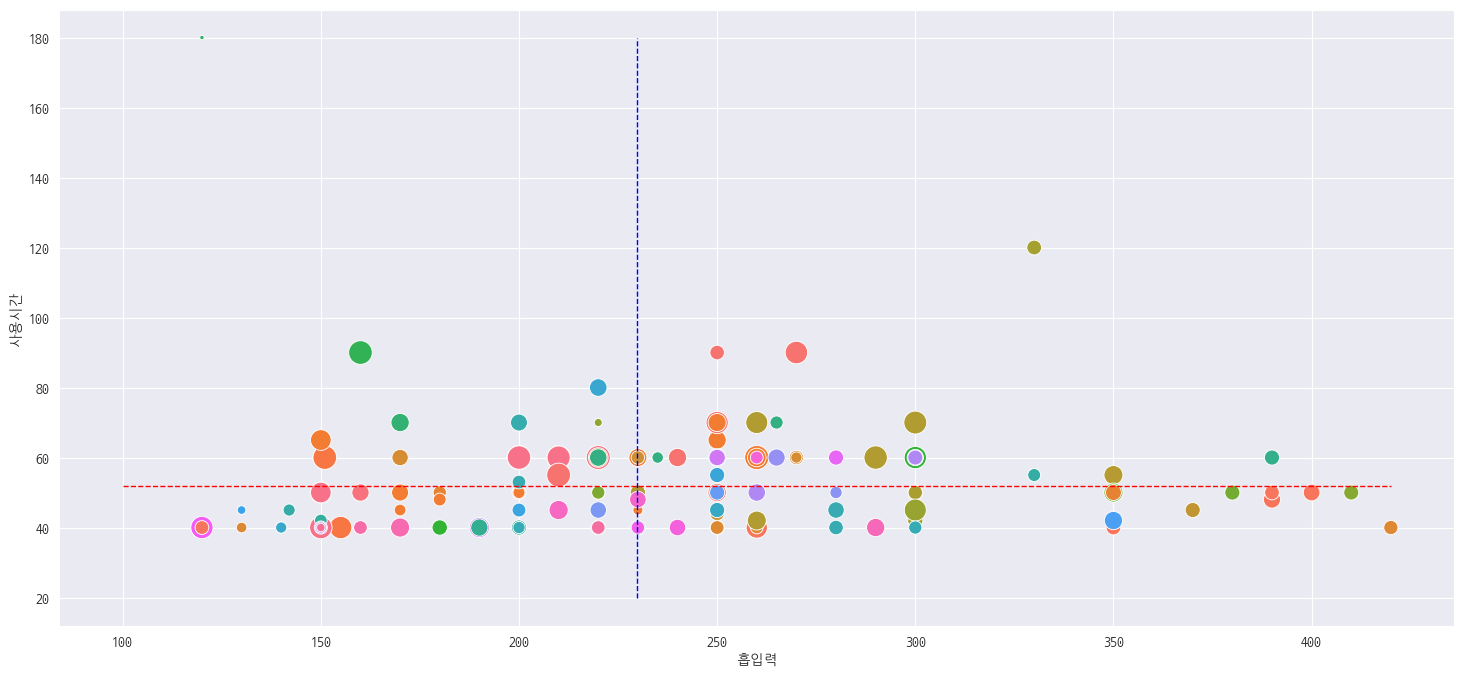

In [104]:
plt.figure(figsize=(18, 8))
sns.scatterplot(data=chartData, x='흡입력', y='사용시간', size='가격', sizes=(10, 300), hue=chartData['회사명'], legend=False)
plt.plot([100, suctionMax], [useTimeMean2, useTimeMean2], 'r--', lw=1)  # 사용시간 평균치 줄표시
plt.plot([suctionMean2, suctionMean2], [20, useTimeMax], 'b--', lw=1)  # 흡입력 평균치 줄 표시
# cursor(hover=True)

plt.show()

In [105]:
## 인기제품 데이터 시각화
chartDataTop = chartData[:20]

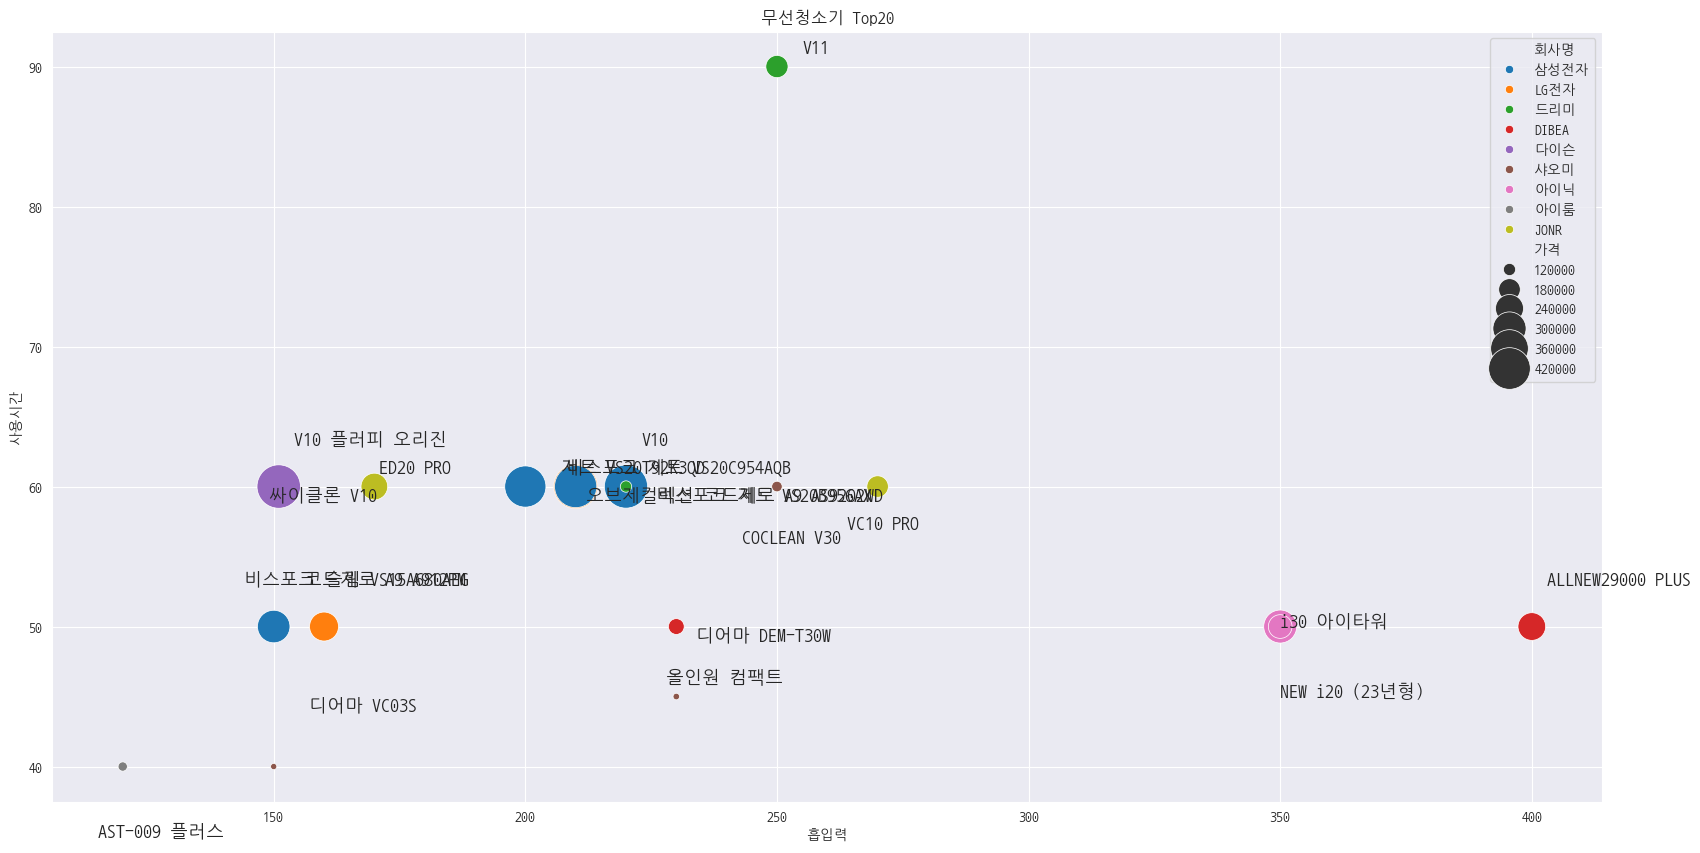

In [129]:
import random
## 인기제품 시각화

fig = plt.figure(figsize=(20, 10))
plt.title('무선청소기 Top20')
sns.scatterplot(data=chartDataTop, x='흡입력', y='사용시간', size='가격', sizes=(20, 1000), hue=chartDataTop['회사명'])

for index, row in chartDataTop.iterrows():
    x = row['흡입력'] + random.randrange(-8, 8)
    y = row['사용시간'] + random.randrange(-5, 5)
    s = row['제품명']
    plt.text(x, y, s, size=13)

plt.show()

##### 결론
- 데이터분석을 위한 전처리는 쉽지 않음
- 결과들이 예상이나, 실제와 다를 수 있음